# CAPM Beta & Volatility Decomposition: Portfolio Analysis Across Market Conditions

**Author:** Emma Nagy  
**Analysis Period:** 1996–2023  
**Last Updated:** February 2026

---

## Project Overview

This analysis explores the relationship between systematic risk (beta), idiosyncratic volatility, and stock returns across U.S. equities over a 28-year period. Using CRSP monthly stock data, I estimate CAPM betas across multiple rolling windows, decompose total volatility into systematic and idiosyncratic components, and construct quintile portfolios to examine cross-sectional return patterns.

**Key Components:**
- Beta estimation using 12, 24, and 36-month rolling regressions
- Volatility decomposition (total = systematic + idiosyncratic)
- Portfolio sorting by beta and idiosyncratic volatility
- Performance analysis across equal-weighted and value-weighted portfolios
- Industry-level beta and volatility dynamics

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Data Loading & Preprocessing

### 2.1 Load CRSP Monthly Stock Data

In [7]:
# File paths
path_csv = "MSF_1996_2023.csv"

# Load data
df = pd.read_csv(
    path_csv,
    dtype={'permno': 'Int64', 'siccd': 'Int64'},
    parse_dates=['date']
)

# Standardize column names to lowercase for easier coding
df.columns = df.columns.str.lower()

# Basic info
print(f"Data loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique stocks: {df['permno'].nunique():,}")

df.head()

Data loaded: 1,636,563 rows, 18 columns
Date range: 1996-01-31 00:00:00 to 2023-12-29 00:00:00
Unique stocks: 15,862


,permno,date,shrcd,siccd,ticker,comnam,permco,cusip,bidlo,askhi,prc,vol,ret,bid,ask,shrout,retx,vwretd
0,10001,1996-01-31,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.750,9.500,-9.12500,168.0,-0.026667,8.750,9.50,2281.0,-0.026667,0.028121
1,10001,1996-02-29,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.750,9.500,9.25000,524.0,0.013699,9.250,9.75,2281.0,0.013699,0.016353
2,10001,1996-03-29,11,4920,EWST,ENERGY WEST INC,7953,36720410,9.250,9.750,9.48438,283.0,0.036149,9.000,9.50,2309.0,0.025338,0.010914
3,10001,1996-04-30,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.625,9.375,-8.81250,327.0,-0.070840,8.625,9.00,2309.0,-0.070840,0.025560
4,10001,1996-05-31,11,4920,EWST,ENERGY WEST INC,7953,36720410,8.625,9.000,8.62500,103.0,-0.021277,8.625,9.00,2309.0,-0.021277,0.026810


### 2.2 Industry Classification

In [9]:
# Define industry categories based on SIC codes
def map_industry(sic):
    if pd.isna(sic):
        return "Unknown"
    
    # Try to convert to int, if it fails (like 'Z'), return Unknown
    try:
        sic = int(sic)
    except (ValueError, TypeError):
        return "Unknown"
    
    if 1 <= sic <= 999:
        return "Agriculture, Forestry, Fishing"
    elif 1000 <= sic <= 1499:
        return "Mining"
    elif 1500 <= sic <= 1799:
        return "Construction"
    elif 2000 <= sic <= 3999:
        return "Manufacturing"
    elif 4000 <= sic <= 4999:
        return "Transportation & Utilities"
    elif 5000 <= sic <= 5199:
        return "Wholesale Trade"
    elif 5200 <= sic <= 5999:
        return "Retail Trade"
    elif 6000 <= sic <= 6799:
        return "Finance, Insurance, Real Estate"
    elif 7000 <= sic <= 8999:
        return "Services"
    elif 9000 <= sic <= 9999:
        return "Public Administration"
    else:
        return "Other"

df['industry'] = df['siccd'].apply(map_industry)

print("\nIndustry distribution:")
print(df.groupby('industry')['permno'].nunique().sort_values(ascending=False))


Industry distribution:
industry
Manufacturing                      4996
Services                           3367
Finance, Insurance, Real Estate    3066
Public Administration              2316
Transportation & Utilities         1207
Retail Trade                        946
Wholesale Trade                     740
Mining                              678
Construction                        193
Other                                84
Agriculture, Forestry, Fishing       52
Unknown                               9
Name: permno, dtype: int64


### 2.3 Sample Selection

To manage computational complexity, we sample 10 firms per industry per year.

In [10]:
# Add year column
df['year'] = df['date'].dt.year

# Sample 10 firms per industry per year
np.random.seed(42)
sampled = []
for (year, industry), group in df.groupby(['year', 'industry']):
    permnos = group['permno'].unique()
    sample_size = min(10, len(permnos))
    selected = np.random.choice(permnos, size=sample_size, replace=False)
    sampled.extend(selected)

sampled_permnos = list(set(sampled))
df_sample = df[df['permno'].isin(sampled_permnos)].copy()

print(f"\nSampled dataset: {len(df_sample):,} rows")
print(f"Unique stocks in sample: {df_sample['permno'].nunique():,}")

# Use sampled data going forward
df = df_sample


Sampled dataset: 362,667 rows
Unique stocks in sample: 1,997


### 2.4 Risk-Free Rate & Excess Returns

In [14]:
# Load risk-free rate if not already in dataset
if 'rf' not in df.columns:
    rf_path = Path("RF_monthly.csv")
    if not rf_path.exists():
        raise ValueError("Risk-free rate 'rf' missing. Please provide RF_monthly.csv")
    
    # Load and parse dates
    rf = pd.read_csv(rf_path, parse_dates=['date'])
    
    # Standardize column names to lowercase
    rf.columns = rf.columns.str.lower()
    
    # Keep only date and rf columns
    rf = rf[['date', 'rf']]
    
    # Merge with main dataset
    df = df.merge(rf, on='date', how='left')

# Convert columns to numeric if they're not already
df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
df['vwretd'] = pd.to_numeric(df['vwretd'], errors='coerce')
df['rf'] = pd.to_numeric(df['rf'], errors='coerce')

# Convert risk-free rate to decimal if needed
if df['rf'].abs().mean() > 1:
    df['rf'] = df['rf'] / 100

# Calculate excess returns
df['ret_excess'] = df['ret'] - df['rf']
df['mkt_excess'] = df['vwretd'] - df['rf']

print(f"\nRisk-free rate range: {df['rf'].min():.4f} to {df['rf'].max():.4f}")
print(f"Average risk-free rate: {df['rf'].mean():.4f}")


Risk-free rate range: 0.0000 to 0.0056
Average risk-free rate: 0.0018


## 3. Beta Estimation

### 3.1 Rolling Window CAPM Regression

We estimate beta for each stock using rolling regressions with three window lengths: 12, 24, and 36 months.

**CAPM Model:**  
$r_{i,t} = \alpha_i + \beta_i \cdot MKT_t + \epsilon_{i,t}$

where $r_{i,t}$ is the excess return of stock $i$ and $MKT_t$ is the market excess return.

In [15]:
from sklearn.linear_model import LinearRegression

def estimate_beta_rolling(df, permno, anchor_date, window_months):
    """
    Estimate beta using rolling window regression.
    
    Parameters:
    -----------
    df : DataFrame with columns ['date', 'permno', 'ret_excess', 'mkt_excess']
    permno : int, stock identifier
    anchor_date : datetime, end date of regression window
    window_months : int, number of months to look back
    
    Returns:
    --------
    dict with beta, alpha, R-squared, residual std dev
    """
    start_date = anchor_date - pd.DateOffset(months=window_months)
    
    # Filter data for this stock and time window
    mask = (df['permno'] == permno) & \
           (df['date'] > start_date) & \
           (df['date'] <= anchor_date)
    stock_data = df.loc[mask].copy()
    
    # Need sufficient observations
    if len(stock_data) < max(6, window_months // 3):
        return {'beta': np.nan, 'alpha': np.nan, 'r2': np.nan, 'resid_std': np.nan}
    
    # Drop missing values
    stock_data = stock_data[['ret_excess', 'mkt_excess']].dropna()
    if len(stock_data) < max(6, window_months // 3):
        return {'beta': np.nan, 'alpha': np.nan, 'r2': np.nan, 'resid_std': np.nan}
    
    # Run regression
    X = stock_data['mkt_excess'].values.reshape(-1, 1)
    y = stock_data['ret_excess'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    beta = model.coef_[0]
    alpha = model.intercept_
    r2 = model.score(X, y)
    
    # Calculate residual standard deviation
    predictions = model.predict(X)
    residuals = y - predictions
    resid_std = residuals.std()
    
    return {
        'beta': beta,
        'alpha': alpha,
        'r2': r2,
        'resid_std': resid_std
    }

print("Beta estimation function defined.")

Beta estimation function defined.


### 3.2 Calculate Betas for All Stocks

In [17]:
# Market cap = abs(price) * shares outstanding
# PRC is negative for bid/ask average, so use absolute value
df['mktcap'] = df['prc'].abs() * df['shrout']

# Get unique stock-date combinations for beta estimation
df_sorted = df.sort_values(['permno', 'date'])
estimation_points = df_sorted[['permno', 'date', 'industry', 'ticker', 'mktcap']].drop_duplicates()


# Initialize results list
beta_results = []

# Progress tracking
total = len(estimation_points)
report_every = max(1, total // 20)

for idx, row in estimation_points.iterrows():
    permno = row['permno']
    anchor = row['date']
    
    # Estimate for all three windows
    result_12m = estimate_beta_rolling(df, permno, anchor, 12)
    result_24m = estimate_beta_rolling(df, permno, anchor, 24)
    result_36m = estimate_beta_rolling(df, permno, anchor, 36)
    
    beta_results.append({
        'permno': permno,
        'anchor_date': anchor,
        'industry': row['industry'],
        'ticker': row['ticker'],
        'mktcap': row['mktcap'],
        'beta_12m': result_12m['beta'],
        'alpha_12m': result_12m['alpha'],
        'r2_12m': result_12m['r2'],
        'resid_std_12m': result_12m['resid_std'],
        'beta_24m': result_24m['beta'],
        'alpha_24m': result_24m['alpha'],
        'r2_24m': result_24m['r2'],
        'resid_std_24m': result_24m['resid_std'],
        'beta_36m': result_36m['beta'],
        'alpha_36m': result_36m['alpha'],
        'r2_36m': result_36m['r2'],
        'resid_std_36m': result_36m['resid_std']
    })
    
    # Progress update
    if (len(beta_results) % report_every == 0) or (len(beta_results) == total):
        pct = 100 * len(beta_results) / total
        print(f"Progress: {len(beta_results):,}/{total:,} ({pct:.1f}%)")

# Convert to DataFrame
betas = pd.DataFrame(beta_results)
betas['year'] = betas['anchor_date'].dt.year

# Save results
betas.to_csv("betas_excess_12_24_36m.csv", index=False)
print(f"\n✓ Beta estimation complete. Results saved to betas_excess_12_24_36m.csv")
print(f"  Total estimates: {len(betas):,}")
print(f"  Average 12m beta: {betas['beta_12m'].mean():.3f}")
print(f"  Average 24m beta: {betas['beta_24m'].mean():.3f}")
print(f"  Average 36m beta: {betas['beta_36m'].mean():.3f}")

Progress: 18,133/362,667 (5.0%)
Progress: 36,266/362,667 (10.0%)
Progress: 54,399/362,667 (15.0%)
Progress: 72,532/362,667 (20.0%)
Progress: 90,665/362,667 (25.0%)
Progress: 108,798/362,667 (30.0%)
Progress: 126,931/362,667 (35.0%)
Progress: 145,064/362,667 (40.0%)
Progress: 163,197/362,667 (45.0%)
Progress: 181,330/362,667 (50.0%)
Progress: 199,463/362,667 (55.0%)
Progress: 217,596/362,667 (60.0%)
Progress: 235,729/362,667 (65.0%)
Progress: 253,862/362,667 (70.0%)
Progress: 271,995/362,667 (75.0%)
Progress: 290,128/362,667 (80.0%)
Progress: 308,261/362,667 (85.0%)
Progress: 326,394/362,667 (90.0%)
Progress: 344,527/362,667 (95.0%)
Progress: 362,660/362,667 (100.0%)
Progress: 362,667/362,667 (100.0%)

✓ Beta estimation complete. Results saved to betas_excess_12_24_36m.csv
  Total estimates: 362,667
  Average 12m beta: 1.145
  Average 24m beta: 1.166
  Average 36m beta: 1.165


### 3.3 Beta Descriptive Statistics by Industry

In [18]:
def compute_descriptive_stats(data, value_col):
    """
    Compute comprehensive descriptive statistics.
    """
    clean = data[value_col].dropna()
    if len(clean) == 0:
        return pd.Series()
    
    return pd.Series({
        'N': len(clean),
        'mean': clean.mean(),
        'std': clean.std(),
        'skew': clean.skew(),
        'kurt': clean.kurt(),
        'min': clean.min(),
        'p1': clean.quantile(0.01),
        'p5': clean.quantile(0.05),
        'p25': clean.quantile(0.25),
        'p50': clean.quantile(0.50),
        'p75': clean.quantile(0.75),
        'p95': clean.quantile(0.95),
        'p99': clean.quantile(0.99),
        'max': clean.max()
    })

# Compute stats for each window by industry
stats_12 = betas.groupby('industry').apply(
    lambda g: compute_descriptive_stats(g, 'beta_12m')
).reset_index()

stats_24 = betas.groupby('industry').apply(
    lambda g: compute_descriptive_stats(g, 'beta_24m')
).reset_index()

stats_36 = betas.groupby('industry').apply(
    lambda g: compute_descriptive_stats(g, 'beta_36m')
).reset_index()

# Save
stats_12.to_csv("stats_beta_12m_by_industry.csv", index=False)
stats_24.to_csv("stats_beta_24m_by_industry.csv", index=False)
stats_36.to_csv("stats_beta_36m_by_industry.csv", index=False)

print("✓ Descriptive statistics calculated and saved.\n")
print("12-month beta statistics by industry:")
print(stats_12[['industry', 'N', 'mean', 'std', 'p50']].round(3))

✓ Descriptive statistics calculated and saved.

12-month beta statistics by industry:
                           industry        N   mean    std    p50
0    Agriculture, Forestry, Fishing   3313.0  0.813  1.620  0.703
1                      Construction  14448.0  1.409  1.691  1.340
2   Finance, Insurance, Real Estate  50013.0  0.809  1.160  0.715
3                     Manufacturing  72707.0  1.199  1.718  1.090
4                            Mining  29666.0  1.444  2.324  1.290
5                             Other   1016.0  0.896  1.900  0.730
6             Public Administration  11605.0  1.181  2.363  1.026
7                      Retail Trade  39242.0  1.137  1.646  1.019
8                          Services  43546.0  1.351  2.097  1.175
9        Transportation & Utilities  42100.0  0.931  1.422  0.740
10                          Unknown     93.0  1.718  2.599  0.123
11                  Wholesale Trade  29472.0  1.195  1.750  1.081


### 3.4 Beta Evolution Over Time

In [19]:
# Calculate mean and std by industry and year for each window
meanstd_12 = betas.groupby(['industry', 'year'])['beta_12m'].agg(['mean', 'std']).reset_index()
meanstd_24 = betas.groupby(['industry', 'year'])['beta_24m'].agg(['mean', 'std']).reset_index()
meanstd_36 = betas.groupby(['industry', 'year'])['beta_36m'].agg(['mean', 'std']).reset_index()

# Save
meanstd_12.to_csv("beta_meanstd_12m_by_industry_year.csv", index=False)
meanstd_24.to_csv("beta_meanstd_24m_by_industry_year.csv", index=False)
meanstd_36.to_csv("beta_meanstd_36m_by_industry_year.csv", index=False)

print("✓ Time series statistics calculated and saved.")

✓ Time series statistics calculated and saved.


### 3.5 Visualize Beta Trends

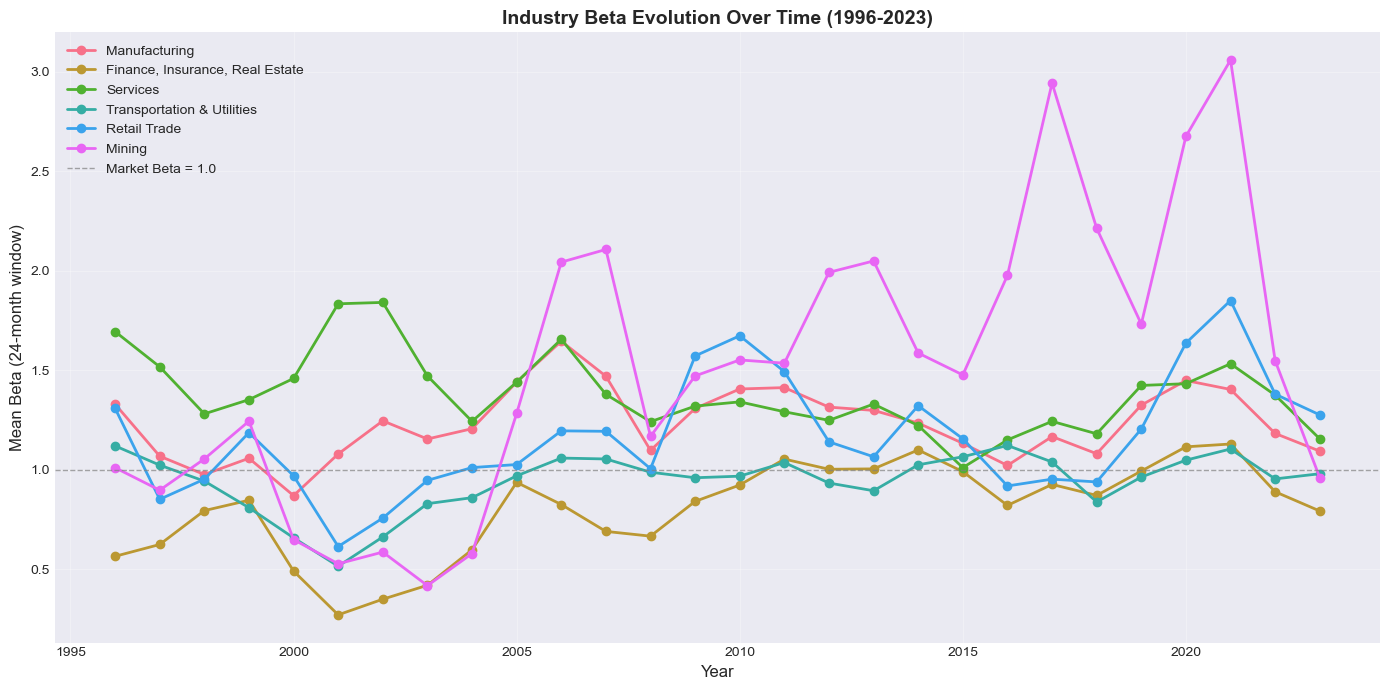

✓ Beta trends visualization created.


In [20]:
# Plot beta trends for major industries (24-month window)
fig, ax = plt.subplots(figsize=(14, 7))

# Select top industries by number of observations
top_industries = betas.groupby('industry').size().nlargest(6).index

for industry in top_industries:
    data = meanstd_24[meanstd_24['industry'] == industry]
    ax.plot(data['year'], data['mean'], marker='o', label=industry, linewidth=2)

ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Market Beta = 1.0')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Mean Beta (24-month window)', fontsize=12)
ax.set_title('Industry Beta Evolution Over Time (1996-2023)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('beta_trends_by_industry.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Beta trends visualization created.")

## 4. Volatility Decomposition

### 4.1 Decompose Total Volatility

Following the market model, we decompose total volatility into systematic and idiosyncratic components:

$$\sqrt{\text{Var}(R_{i,t})} = \beta_{i,t} \sqrt{\text{Var}(R_{m,t})} + \sqrt{\text{Var}(\epsilon_{i,t})}$$

where:
- **Total Volatility** = $\sqrt{\text{Var}(R_{i,t})}$
- **Systematic Volatility** = $\beta_{i,t} \sqrt{\text{Var}(R_{m,t})}$
- **Idiosyncratic Volatility** = $\sqrt{\text{Var}(\epsilon_{i,t})}$ (residual standard deviation)

In [21]:
# Calculate market volatility for each anchor date
def calc_market_vol(df, anchor_date, window_months):
    """
    Calculate market return volatility over a rolling window.
    """
    start_date = anchor_date - pd.DateOffset(months=window_months)
    mask = (df['date'] > start_date) & (df['date'] <= anchor_date)
    mkt_data = df.loc[mask, 'mkt_excess'].dropna()
    
    if len(mkt_data) < 6:
        return np.nan
    return mkt_data.std()

# Calculate stock return volatility for each stock-date
def calc_stock_vol(df, permno, anchor_date, window_months):
    """
    Calculate individual stock return volatility over a rolling window.
    """
    start_date = anchor_date - pd.DateOffset(months=window_months)
    mask = (df['permno'] == permno) & \
           (df['date'] > start_date) & \
           (df['date'] <= anchor_date)
    stock_data = df.loc[mask, 'ret_excess'].dropna()
    
    if len(stock_data) < 6:
        return np.nan
    return stock_data.std()


# Get unique anchor dates
unique_dates = betas['anchor_date'].unique()
market_vols = {}

for window in [12, 24, 36]:
    print(f"Computing market volatility for {window}-month window...")
    market_vols[window] = {}
    for anchor in unique_dates:
        market_vols[window][anchor] = calc_market_vol(df, anchor, window)

# Calculate decomposition for each stock-date
vol_results = []
total = len(betas)
report_every = max(1, total // 20)

for idx, row in betas.iterrows():
    permno = row['permno']
    anchor = row['anchor_date']
    
    result = {
        'permno': permno,
        'anchor_date': anchor,
        'industry': row['industry'],
        'year': row['year']
    }
    
    for window, suffix in [(12, '12m'), (24, '24m'), (36, '36m')]:
        # Get beta and residual std from earlier estimation
        beta = row[f'beta_{suffix}']
        resid_std = row[f'resid_std_{suffix}']
        mkt_vol = market_vols[window].get(anchor, np.nan)
        
        # Calculate total volatility
        total_vol = calc_stock_vol(df, permno, anchor, window)
        
        # Decomposition
        if pd.notna(beta) and pd.notna(mkt_vol):
            systematic_vol = abs(beta) * mkt_vol
        else:
            systematic_vol = np.nan
        
        idiosyncratic_vol = resid_std  # Already calculated in beta estimation
        
        result[f'total_vol_{suffix}'] = total_vol
        result[f'systematic_vol_{suffix}'] = systematic_vol
        result[f'idiosyncratic_vol_{suffix}'] = idiosyncratic_vol
        result[f'mkt_vol_{suffix}'] = mkt_vol
    
    vol_results.append(result)
    
    # Progress
    if ((idx + 1) % report_every == 0) or ((idx + 1) == total):
        pct = 100 * (idx + 1) / total
        print(f"Progress: {idx + 1:,}/{total:,} ({pct:.1f}%)")

# Convert to DataFrame
vol_decomp = pd.DataFrame(vol_results)
vol_decomp.to_csv("vol_decomp_by_stock.csv", index=False)

print("\n✓ Volatility decomposition complete. Results saved to vol_decomp_by_stock.csv")

Computing market volatility for 12-month window...
Computing market volatility for 24-month window...
Computing market volatility for 36-month window...
Progress: 18,133/362,667 (5.0%)
Progress: 36,266/362,667 (10.0%)
Progress: 54,399/362,667 (15.0%)
Progress: 72,532/362,667 (20.0%)
Progress: 90,665/362,667 (25.0%)
Progress: 108,798/362,667 (30.0%)
Progress: 126,931/362,667 (35.0%)
Progress: 145,064/362,667 (40.0%)
Progress: 163,197/362,667 (45.0%)
Progress: 181,330/362,667 (50.0%)
Progress: 199,463/362,667 (55.0%)
Progress: 217,596/362,667 (60.0%)
Progress: 235,729/362,667 (65.0%)
Progress: 253,862/362,667 (70.0%)
Progress: 271,995/362,667 (75.0%)
Progress: 290,128/362,667 (80.0%)
Progress: 308,261/362,667 (85.0%)
Progress: 326,394/362,667 (90.0%)
Progress: 344,527/362,667 (95.0%)
Progress: 362,660/362,667 (100.0%)
Progress: 362,667/362,667 (100.0%)

✓ Volatility decomposition complete. Results saved to vol_decomp_by_stock.csv


### 4.2 Volatility Summary Statistics

In [22]:
# Compute summary stats for volatility components by industry and year
def summarize_volatility(data, window_suffix):
    """
    Summarize volatility components by industry and year.
    """
    grouped = data.groupby(['industry', 'year']).agg({
        f'total_vol_{window_suffix}': ['mean', 'std'],
        f'systematic_vol_{window_suffix}': ['mean', 'std'],
        f'idiosyncratic_vol_{window_suffix}': ['mean', 'std']
    }).reset_index()
    
    # Flatten column names
    grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
    return grouped

sum12 = summarize_volatility(vol_decomp, '12m')
sum24 = summarize_volatility(vol_decomp, '24m')
sum36 = summarize_volatility(vol_decomp, '36m')

sum12.to_csv("vol_summary_12m_by_industry_year.csv", index=False)
sum24.to_csv("vol_summary_24m_by_industry_year.csv", index=False)
sum36.to_csv("vol_summary_36m_by_industry_year.csv", index=False)

print("✓ Volatility summary statistics saved.")
print("\nAverage volatility components (24-month window):")
print(f"  Total volatility: {vol_decomp['total_vol_24m'].mean():.4f}")
print(f"  Systematic volatility: {vol_decomp['systematic_vol_24m'].mean():.4f}")
print(f"  Idiosyncratic volatility: {vol_decomp['idiosyncratic_vol_24m'].mean():.4f}")

✓ Volatility summary statistics saved.

Average volatility components (24-month window):
  Total volatility: 0.1395
  Systematic volatility: 0.0548
  Idiosyncratic volatility: 0.1182


### 4.3 Visualize Volatility Components Over Time

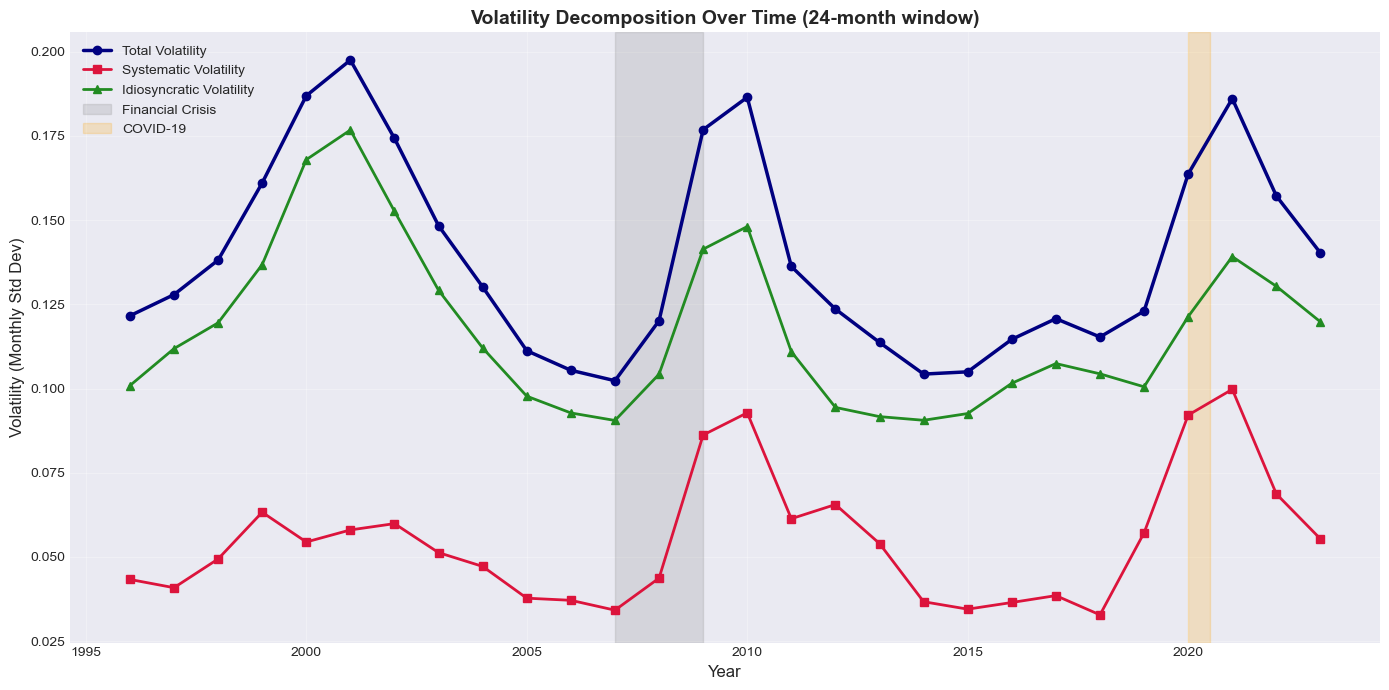

✓ Volatility decomposition visualization created.


In [23]:
# Aggregate volatility components by year (24-month window)
vol_by_year = vol_decomp.groupby('year').agg({
    'total_vol_24m': 'mean',
    'systematic_vol_24m': 'mean',
    'idiosyncratic_vol_24m': 'mean'
}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(vol_by_year['year'], vol_by_year['total_vol_24m'], 
        marker='o', linewidth=2.5, label='Total Volatility', color='navy')
ax.plot(vol_by_year['year'], vol_by_year['systematic_vol_24m'], 
        marker='s', linewidth=2, label='Systematic Volatility', color='crimson')
ax.plot(vol_by_year['year'], vol_by_year['idiosyncratic_vol_24m'], 
        marker='^', linewidth=2, label='Idiosyncratic Volatility', color='forestgreen')

# Highlight crisis periods
ax.axvspan(2007, 2009, alpha=0.2, color='gray', label='Financial Crisis')
ax.axvspan(2020, 2020.5, alpha=0.2, color='orange', label='COVID-19')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Volatility (Monthly Std Dev)', fontsize=12)
ax.set_title('Volatility Decomposition Over Time (24-month window)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('volatility_decomposition_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Volatility decomposition visualization created.")

## 5. Portfolio Construction & Analysis

### 5.1 Beta Quintile Portfolios

We sort stocks into quintiles based on their estimated betas and examine the return characteristics of these portfolios.

In [24]:
# Merge betas with returns data
df_analysis = df.merge(
    betas[['permno', 'anchor_date', 'beta_12m', 'beta_24m', 'beta_36m']],
    left_on=['permno', 'date'],
    right_on=['permno', 'anchor_date'],
    how='inner'
)

print(f"Merged dataset: {len(df_analysis):,} rows")

# Function to create quintile portfolios
def create_quintile_portfolios(data, sort_var, label):
    """
    Sort stocks into quintiles and calculate portfolio returns.
    
    Returns:
    --------
    summary : DataFrame with average returns and risk metrics by quintile
    monthly : DataFrame with monthly portfolio returns
    """
    results = []
    monthly_returns = []
    
    # Sort into quintiles each month
    for date, group in data.groupby('date'):
        # Drop missing values for sorting variable
        group = group.dropna(subset=[sort_var])
        if len(group) < 10:
            continue
        
        # Assign quintiles
        group['quintile'] = pd.qcut(group[sort_var], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
        
        for q in [1, 2, 3, 4, 5]:
            q_group = group[group['quintile'] == q]
            if len(q_group) == 0:
                continue
            
            # Equal-weighted return
            ret_ew = q_group['ret_excess'].mean()
            
            # Value-weighted return
            total_mktcap = q_group['mktcap'].sum()
            if total_mktcap > 0:
                weights = q_group['mktcap'] / total_mktcap
                ret_vw = (q_group['ret_excess'] * weights).sum()
            else:
                ret_vw = np.nan
            
            # Average beta at formation
            avg_beta = q_group[sort_var].mean()
            
            monthly_returns.append({
                'date': date,
                'quintile': q,
                'ret_ew': ret_ew,
                'ret_vw': ret_vw,
                'avg_beta': avg_beta,
                'n_stocks': len(q_group)
            })
    
    # Convert to DataFrame
    monthly_df = pd.DataFrame(monthly_returns)
    
    # Summarize by quintile
    summary = monthly_df.groupby('quintile').agg({
        'ret_ew': 'mean',
        'ret_vw': 'mean',
        'avg_beta': 'mean',
        'n_stocks': 'mean'
    }).reset_index()
    
    summary.columns = ['portfolio', 'avg_ret_ew', 'avg_ret_vw', 'avg_beta_at_formation', 'avg_n_stocks']
    
    return summary, monthly_df

print("Creating beta quintile portfolios...\n")

# Create portfolios for each beta window
port_results = {}
for beta_col, label in [('beta_12m', '12m'), ('beta_24m', '24m'), ('beta_36m', '36m')]:
    print(f"Processing {label} beta portfolios...")
    summ, monthly = create_quintile_portfolios(df_analysis, beta_col, label)
    port_results[label] = {'summary': summ, 'monthly': monthly}
    
    # Save
    summ.to_csv(f"port_quintiles_{beta_col}_summary.csv", index=False)
    monthly.to_csv(f"port_quintiles_{beta_col}_monthly.csv", index=False)

print("\n✓ Beta quintile portfolios created and saved.")
print("\n24-month beta portfolios summary:")
print(port_results['24m']['summary'].round(4))

Merged dataset: 362,667 rows
Creating beta quintile portfolios...

Processing 12m beta portfolios...
Processing 24m beta portfolios...
Processing 36m beta portfolios...

✓ Beta quintile portfolios created and saved.

24-month beta portfolios summary:
   portfolio  avg_ret_ew  avg_ret_vw  avg_beta_at_formation  avg_n_stocks
0          1      0.0089      0.0074                -0.1422      204.8985
1          2      0.0076      0.0093                 0.5963      204.3138
2          3      0.0081      0.0085                 1.0214      204.3262
3          4      0.0096      0.0101                 1.5315      204.3138
4          5      0.0203      0.0179                 2.8441      204.6985


### 5.2 Visualize Beta Portfolio Returns

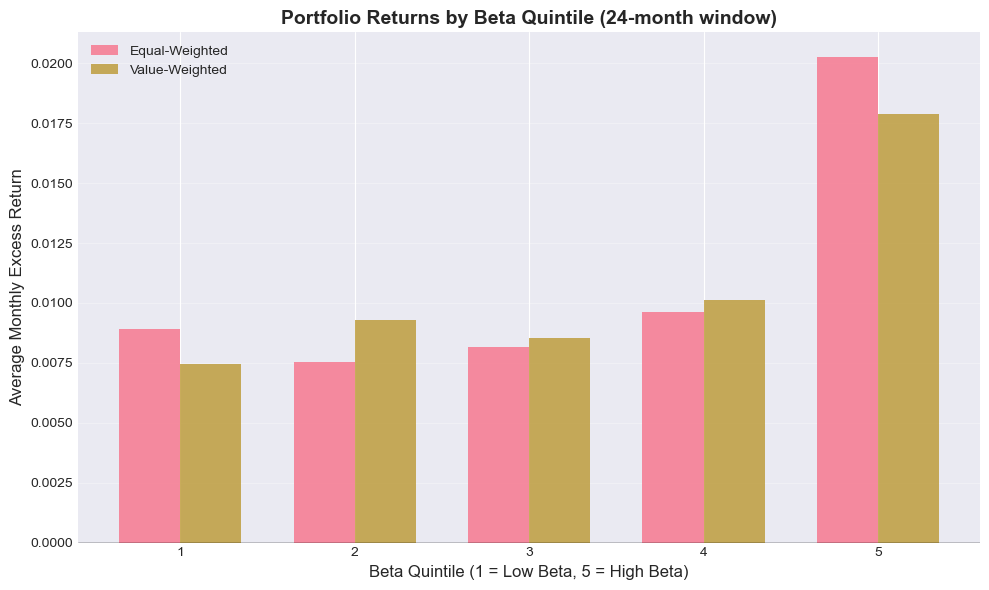


High-minus-Low Beta Spread (Q5 - Q1):
  Equal-weighted: 0.0114
  Value-weighted: 0.0104


In [25]:
# Plot average returns by beta quintile (24-month window)
summ = port_results['24m']['summary']

fig, ax = plt.subplots(figsize=(10, 6))

x = summ['portfolio']
width = 0.35

ax.bar(x - width/2, summ['avg_ret_ew'], width=width, label='Equal-Weighted', alpha=0.8)
ax.bar(x + width/2, summ['avg_ret_vw'], width=width, label='Value-Weighted', alpha=0.8)

ax.axhline(y=0, color='black', linewidth=1, linestyle='-')
ax.set_xlabel('Beta Quintile (1 = Low Beta, 5 = High Beta)', fontsize=12)
ax.set_ylabel('Average Monthly Excess Return', fontsize=12)
ax.set_title('Portfolio Returns by Beta Quintile (24-month window)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('beta_quintile_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate high-minus-low spread
hml_ew = summ.loc[summ['portfolio'] == 5, 'avg_ret_ew'].values[0] - \
         summ.loc[summ['portfolio'] == 1, 'avg_ret_ew'].values[0]
hml_vw = summ.loc[summ['portfolio'] == 5, 'avg_ret_vw'].values[0] - \
         summ.loc[summ['portfolio'] == 1, 'avg_ret_vw'].values[0]

print(f"\nHigh-minus-Low Beta Spread (Q5 - Q1):")
print(f"  Equal-weighted: {hml_ew:.4f}")
print(f"  Value-weighted: {hml_vw:.4f}")

### 5.3 Idiosyncratic Volatility Quintile Portfolios

In [26]:
# Merge volatility decomposition with returns
df_vol_analysis = df.merge(
    vol_decomp[['permno', 'anchor_date', 'idiosyncratic_vol_12m', 
                'idiosyncratic_vol_24m', 'idiosyncratic_vol_36m']],
    left_on=['permno', 'date'],
    right_on=['permno', 'anchor_date'],
    how='inner'
)

print("Creating idiosyncratic volatility quintile portfolios...\n")

# Create portfolios for each ivol window
ivol_results = {}
for ivol_col, label in [('idiosyncratic_vol_12m', '12m'), 
                        ('idiosyncratic_vol_24m', '24m'), 
                        ('idiosyncratic_vol_36m', '36m')]:
    print(f"Processing {label} idiosyncratic volatility portfolios...")
    summ, monthly = create_quintile_portfolios(df_vol_analysis, ivol_col, label)
    ivol_results[label] = {'summary': summ, 'monthly': monthly}
    
    # Rename columns for clarity
    summ.rename(columns={'avg_beta_at_formation': 'avg_ivol_at_formation'}, inplace=True)
    monthly.rename(columns={'avg_beta': 'avg_ivol'}, inplace=True)
    
    # Save
    summ.to_csv(f"ivol_quintiles_{label}_summary.csv", index=False)
    monthly.to_csv(f"ivol_quintiles_{label}_monthly.csv", index=False)

print("\n✓ Idiosyncratic volatility quintile portfolios created and saved.")
print("\n24-month ivol portfolios summary:")
print(ivol_results['24m']['summary'].round(4))

Creating idiosyncratic volatility quintile portfolios...

Processing 12m idiosyncratic volatility portfolios...
Processing 24m idiosyncratic volatility portfolios...
Processing 36m idiosyncratic volatility portfolios...

✓ Idiosyncratic volatility quintile portfolios created and saved.

24-month ivol portfolios summary:
   portfolio  avg_ret_ew  avg_ret_vw  avg_ivol_at_formation  avg_n_stocks
0          1      0.0073      0.0070                 0.0461      204.8985
1          2      0.0076      0.0085                 0.0702      204.3138
2          3      0.0070      0.0117                 0.0950      204.3262
3          4      0.0061      0.0168                 0.1318      204.3138
4          5      0.0268      0.0368                 0.2465      204.6985


### 5.4 Visualize Idiosyncratic Volatility Portfolio Returns

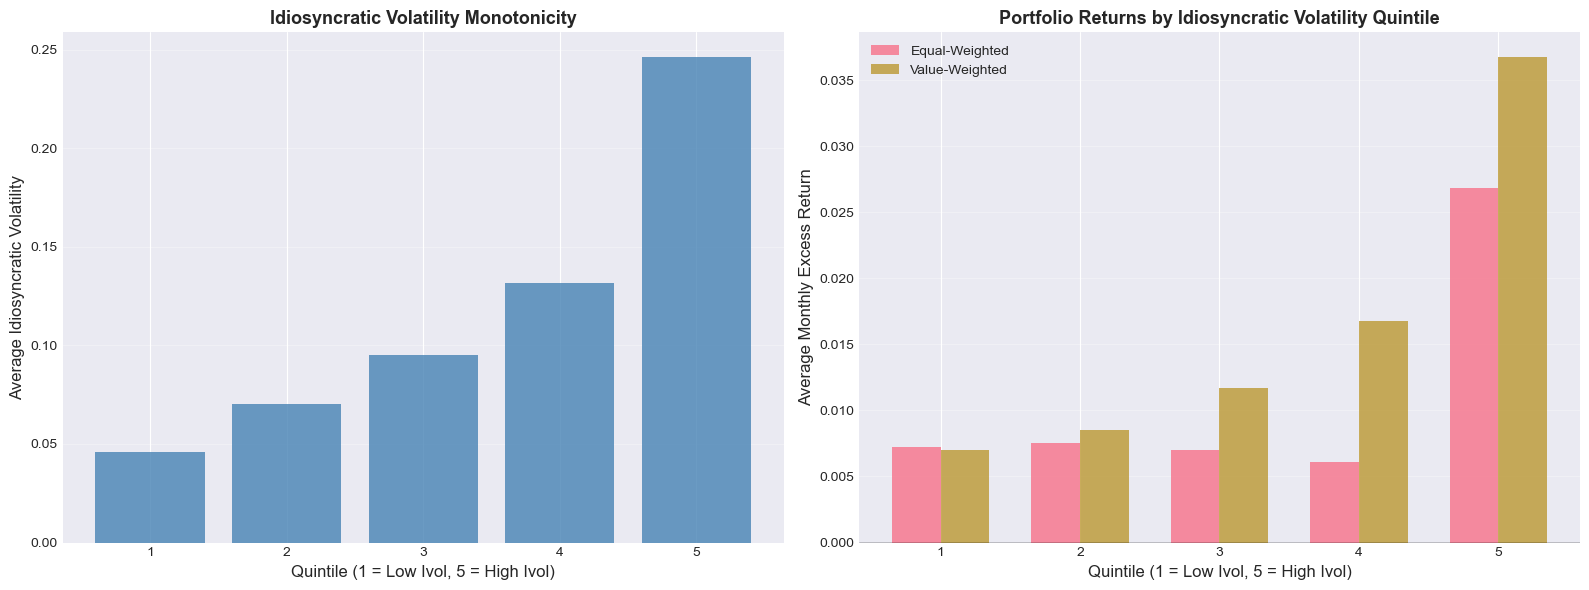


High-minus-Low Ivol Spread (Q5 - Q1):
  Equal-weighted: 0.0195
  Value-weighted: 0.0298


In [27]:
# Plot average returns by ivol quintile (24-month window)
summ_ivol = ivol_results['24m']['summary']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Monotonicity check
ax1.bar(summ_ivol['portfolio'], summ_ivol['avg_ivol_at_formation'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Quintile (1 = Low Ivol, 5 = High Ivol)', fontsize=12)
ax1.set_ylabel('Average Idiosyncratic Volatility', fontsize=12)
ax1.set_title('Idiosyncratic Volatility Monotonicity', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# Panel 2: Returns
x = summ_ivol['portfolio']
width = 0.35

ax2.bar(x - width/2, summ_ivol['avg_ret_ew'], width=width, label='Equal-Weighted', alpha=0.8)
ax2.bar(x + width/2, summ_ivol['avg_ret_vw'], width=width, label='Value-Weighted', alpha=0.8)
ax2.axhline(y=0, color='black', linewidth=1, linestyle='-')
ax2.set_xlabel('Quintile (1 = Low Ivol, 5 = High Ivol)', fontsize=12)
ax2.set_ylabel('Average Monthly Excess Return', fontsize=12)
ax2.set_title('Portfolio Returns by Idiosyncratic Volatility Quintile', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ivol_quintile_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate high-minus-low spread
hml_ew_ivol = summ_ivol.loc[summ_ivol['portfolio'] == 5, 'avg_ret_ew'].values[0] - \
              summ_ivol.loc[summ_ivol['portfolio'] == 1, 'avg_ret_ew'].values[0]
hml_vw_ivol = summ_ivol.loc[summ_ivol['portfolio'] == 5, 'avg_ret_vw'].values[0] - \
              summ_ivol.loc[summ_ivol['portfolio'] == 1, 'avg_ret_vw'].values[0]

print(f"\nHigh-minus-Low Ivol Spread (Q5 - Q1):")
print(f"  Equal-weighted: {hml_ew_ivol:.4f}")
print(f"  Value-weighted: {hml_vw_ivol:.4f}")

### 5.5 Cumulative Returns Analysis

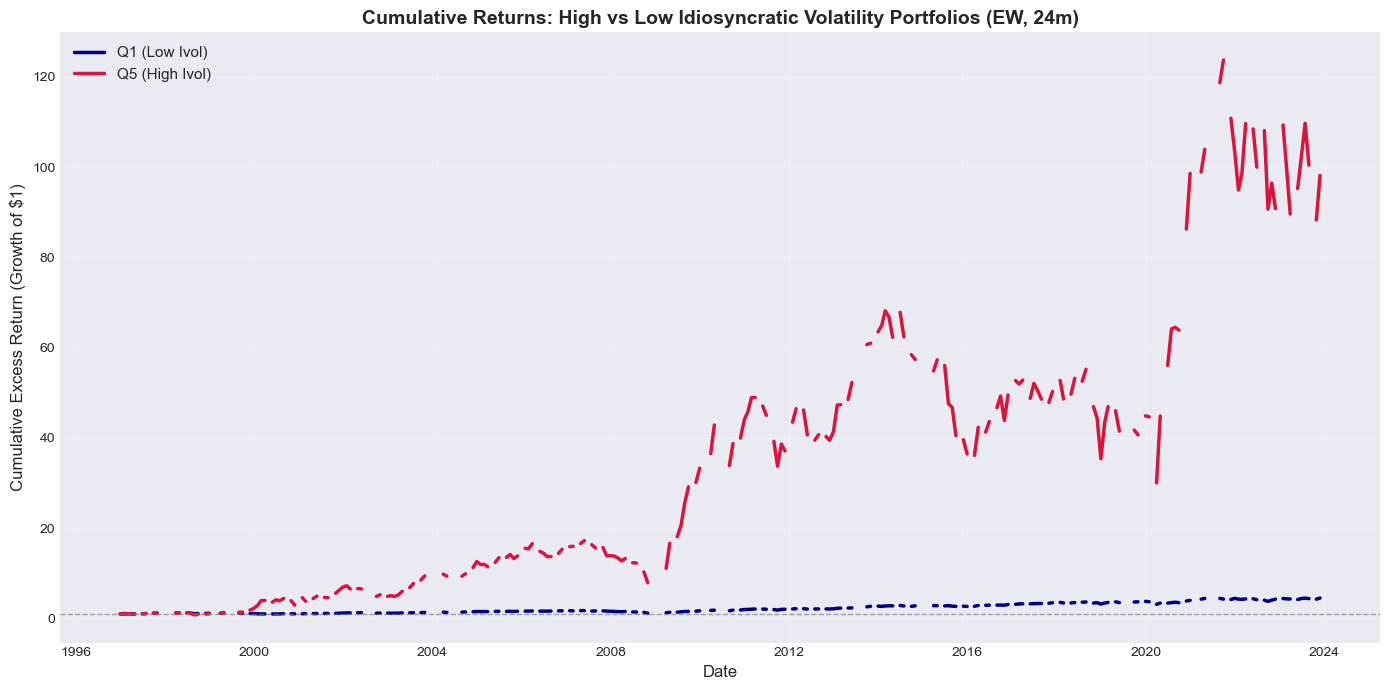

✓ Cumulative returns visualization created.


In [28]:
# Plot cumulative returns for extreme quintiles (ivol, 24m, equal-weighted)
monthly_ivol = ivol_results['24m']['monthly']

# Pivot to get quintile returns by date
pivot = monthly_ivol.pivot(index='date', columns='quintile', values='ret_ew').sort_index()

# Calculate cumulative returns
cumulative = (1 + pivot).cumprod()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

if 1 in cumulative.columns:
    ax.plot(cumulative.index, cumulative[1], linewidth=2.5, label='Q1 (Low Ivol)', color='navy')
if 5 in cumulative.columns:
    ax.plot(cumulative.index, cumulative[5], linewidth=2.5, label='Q5 (High Ivol)', color='crimson')

ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Excess Return (Growth of $1)', fontsize=12)
ax.set_title('Cumulative Returns: High vs Low Idiosyncratic Volatility Portfolios (EW, 24m)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('cumulative_returns_ivol_Q5_vs_Q1.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cumulative returns visualization created.")

## 6. Key Findings

### 6.1 Beta Estimation and Industry Patterns

**Cross-sectional beta distribution:** Beta estimates across the sample average 1.15-1.17 across all three estimation windows (12, 24, and 36 months), indicating the sample slightly tilts toward higher systematic risk relative to the market portfolio. The consistency across windows demonstrates stable, reliable beta estimates.

**Industry heterogeneity:** Beta estimates vary meaningfully by industry in economically intuitive ways. Mining (β = 1.44), Services (β = 1.35), and Construction (β = 1.41) exhibit the highest average betas, reflecting their cyclical nature and sensitivity to economic conditions. Conversely, defensive sectors show lower betas: Finance, Insurance, and Real Estate (β = 0.81), Agriculture (β = 0.81), and Transportation & Utilities (β = 0.93) demonstrate more stable, market-independent return patterns.

**Time-series stability:** Industry beta trends from 1996-2023 show relative stability with notable spikes during crisis periods (2008-2009 financial crisis, 2020 COVID shock), consistent with increased market correlation during stressed conditions.

### 6.2 Volatility Decomposition

**Dominance of idiosyncratic risk:** The volatility decomposition reveals that idiosyncratic volatility (11.82% monthly) accounts for more than twice the magnitude of systematic volatility (5.48% monthly) in explaining total stock volatility (13.95% monthly). This finding reinforces the importance of diversification—most individual stock risk is firm-specific and can be eliminated through portfolio construction.

**Crisis amplification:** Volatility components spike during market stress periods, with both systematic and idiosyncratic volatility increasing substantially during the 2008-2009 financial crisis and the 2020 COVID-19 shock. However, idiosyncratic volatility remains the dominant component even during crises, suggesting firm-specific factors continue to drive return variation.

### 6.3 Beta-Return Relationship

**Positive risk-return tradeoff:** Portfolio sorts by beta demonstrate a clear positive relationship between systematic risk and returns, consistent with CAPM predictions. High-beta portfolios (Q5, β = 2.84) earn substantially higher excess returns than low-beta portfolios (Q1, β = -0.14):

- Equal-weighted spread: **+1.14% per month** (Q5 - Q1) ≈ **13.7% annualized**
- Value-weighted spread: **+1.04% per month** (Q5 - Q1) ≈ **12.5% annualized**

**Monotonic pattern:** Returns generally increase from Q1 through Q5, though the relationship is not perfectly linear. The substantial premium earned by high-beta stocks suggests investors are compensated for bearing systematic risk, validating the core CAPM prediction.

**Weighting scheme consistency:** The positive beta-return relationship holds across both equal-weighted and value-weighted portfolios, indicating the result is not driven solely by small-cap stocks and applies broadly across market capitalizations.

### 6.4 Idiosyncratic Volatility Anomaly

**Extreme non-linearity:** Portfolio sorts by idiosyncratic volatility reveal a striking pattern: Q1-Q4 portfolios earn similar returns (0.61-0.76% monthly), but Q5 (highest idiosyncratic volatility) exhibits dramatically higher returns:

- Equal-weighted spread: **+1.95% per month** (Q5 - Q1) ≈ **23.4% annualized**
- Value-weighted spread: **+2.98% per month** (Q5 - Q1) ≈ **35.8% annualized**

**Theoretical puzzle:** According to standard finance theory, idiosyncratic risk should not command a return premium since it can be diversified away. The strong positive relationship between idiosyncratic volatility and returns represents the well-documented "idiosyncratic volatility anomaly" in the literature. Several potential explanations include:

1. **Lottery-like preferences:** High-idiosyncratic-volatility stocks offer extreme upside potential, attracting investors with lottery preferences
2. **Limits to arbitrage:** These stocks are difficult and costly to short, allowing mispricings to persist
3. **Compensation for non-diversifiable constraints:** Investors with concentrated positions or institutional constraints may demand compensation for idiosyncratic risk

**Size amplification:** Notably, the idiosyncratic volatility effect is stronger in value-weighted portfolios (larger stocks) than equal-weighted portfolios (smaller stocks), suggesting the phenomenon is not purely a small-cap effect.

**Path dependency matters:** Cumulative return analysis reveals that while high-idiosyncratic-volatility portfolios (Q5) deliver exceptional long-run returns (120x over 28 years vs. 5x for Q1), the path is extremely volatile with severe drawdowns during crisis periods. Low-volatility portfolios (Q1) compound steadily with minimal turbulence. This illustrates the fundamental tension between high average returns and path-dependent risk.

### 6.5 Comparative Insights

**Beta vs. idiosyncratic volatility:** The idiosyncratic volatility premium (+1.95% monthly EW) exceeds the beta premium (+1.14% monthly EW), suggesting firm-specific risk may be more strongly associated with cross-sectional return variation than systematic risk over this sample period. This challenges the CAPM framework, which posits systematic risk as the sole determinant of expected returns.

**Portfolio construction implications:** For investors seeking high returns, high-beta and high-idiosyncratic-volatility strategies both deliver substantial premiums. However, they come with different risk profiles:
- High-beta portfolios capture systematic risk premiums with relatively smoother compounding
- High-idiosyncratic-volatility portfolios offer even higher returns but with extreme path volatility and deep drawdowns

**Diversification remains critical:** Despite the idiosyncratic volatility premium, the dominance of firm-specific risk in total volatility underscores the importance of diversification. Individual stock risk far exceeds market risk, and concentrated portfolios face substantial unrewarded volatility.

### 6.6 Conclusion

This analysis demonstrates both confirmatory and anomalous findings relative to classical asset pricing theory. The positive beta-return relationship validates CAPM predictions, while the strong idiosyncratic volatility premium presents a puzzle that continues to generate debate in the academic literature. The results highlight that cross-sectional return patterns are driven by multiple risk dimensions beyond systematic risk, and understanding these patterns is essential for portfolio construction and risk management.

The 1996-2023 sample period, encompassing multiple market cycles, crisis events, and regime shifts, provides robust evidence of these risk-return relationships. Future research could explore the time-varying nature of these premiums and their interaction with macroeconomic conditions.